<a href="https://colab.research.google.com/github/Rys053/Test/blob/main/Household_Electric_Power_Consumption_prediction_with_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'electric-power-consumption-data-set' dataset.
Path to dataset files: /kaggle/input/electric-power-consumption-data-set


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


In [4]:
data = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt",
                   sep=';', parse_dates={'datetime':['Date','Time']}, infer_datetime_format=True,
                   na_values=['?'], low_memory=False)

/tmp/ipython-input-2882046024.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt",
/tmp/ipython-input-2882046024.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt",
/tmp/ipython-input-2882046024.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_

In [5]:
data = data[['datetime','Global_active_power']].dropna()
data['Global_active_power'] = data['Global_active_power'].astype(float)

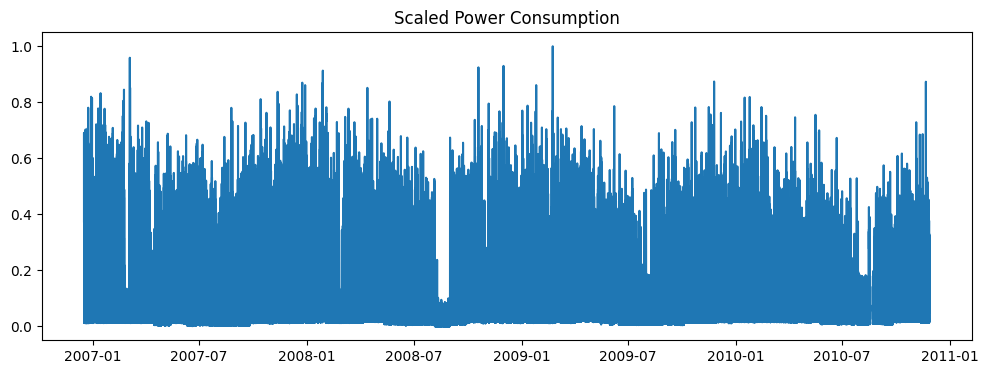

In [6]:
scaler = MinMaxScaler()
data['scaled'] = scaler.fit_transform(data[['Global_active_power']])
series = data['scaled'].values

plt.figure(figsize=(12,4))
plt.plot(data['datetime'], series)
plt.title("Scaled Power Consumption")
plt.show()

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, series, seq_len=48, pred_len=1):
        self.series = series
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.series) - self.seq_len - self.pred_len

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.seq_len]
        y = self.series[idx+self.seq_len:idx+self.seq_len+self.pred_len]
        return torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32)

In [8]:
seq_len = 48   # 과거 48시간 사용
pred_len = 1   # 다음 1시간 예측
dataset = TimeSeriesDataset(series, seq_len, pred_len)

train_size = int(len(dataset)*0.8)
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [9]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.1, pred_len=1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, pred_len)

    def forward(self, x):
        x = self.input_proj(x)            # (batch, seq_len, d_model)
        x = x.permute(1,0,2)              # (seq_len, batch, d_model)
        x = self.transformer(x)           # (seq_len, batch, d_model)
        x = x[-1,:,:]                     # 마지막 시점
        out = self.decoder(x)             # (batch, pred_len)
        return out

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TimeSeriesTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    avg_loss = total_loss / len(train_loader)

    # 검증
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_pred_val = model(x_val)
            val_loss += criterion(y_pred_val, y_val).item()
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.6f}, Val Loss: {val_loss:.6f}")


Epoch 1/10, Train Loss: 0.001362, Val Loss: 0.000409


Epoch 2/10, Train Loss: 0.000693, Val Loss: 0.000528


Epoch 3/10, Train Loss: 0.000666, Val Loss: 0.000434


Epoch 4/10, Train Loss: 0.000656, Val Loss: 0.000392


Epoch 5/10, Train Loss: 0.000650, Val Loss: 0.000421


Epoch 6/10, Train Loss: 0.000647, Val Loss: 0.000401


Epoch 7/10, Train Loss: 0.000645, Val Loss: 0.000470


Epoch 8/10, Train Loss: 0.000644, Val Loss: 0.000400


Epoch 9/10, Train Loss: 0.000641, Val Loss: 0.000422


Epoch 10/10, Train Loss: 0.000640, Val Loss: 0.000475


In [11]:
model.eval()
preds = []
with torch.no_grad():
    for i in range(len(series)-seq_len):
        x_input = torch.tensor(series[i:i+seq_len], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
        y_out = model(x_input)
        preds.append(y_out.cpu().numpy().flatten()[0])

plt.figure(figsize=(12,4))
plt.plot(series, label="Ground Truth")
plt.plot(range(seq_len, len(series)), preds, label="Predictions")
plt.legend()
plt.title("Transformer Time Series Prediction")
plt.show()

KeyboardInterrupt: 

Validation RMSE: 0.021797


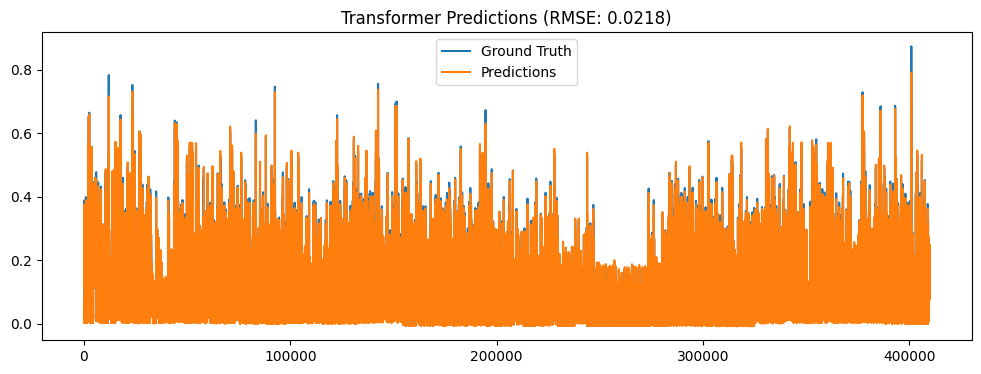

In [12]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error

# RMSE
def evaluate_rmse(model, data_loader, device):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)

            preds.append(outputs.cpu().numpy())
            trues.append(y_batch.cpu().numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    rmse = np.sqrt(mean_squared_error(trues, preds))
    return rmse, trues, preds

rmse, trues, preds = evaluate_rmse(model, val_loader, device)
print(f"Validation RMSE: {rmse:.6f}")

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(trues, label="Ground Truth")
plt.plot(preds, label="Predictions")
plt.title(f"Transformer Predictions (RMSE: {rmse:.4f})")
plt.legend()
plt.show()
